In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets

In [2]:
print(X.info()) #0 missing values across all columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   radius1             569 non-null    float64
 1   texture1            569 non-null    float64
 2   perimeter1          569 non-null    float64
 3   area1               569 non-null    float64
 4   smoothness1         569 non-null    float64
 5   compactness1        569 non-null    float64
 6   concavity1          569 non-null    float64
 7   concave_points1     569 non-null    float64
 8   symmetry1           569 non-null    float64
 9   fractal_dimension1  569 non-null    float64
 10  radius2             569 non-null    float64
 11  texture2            569 non-null    float64
 12  perimeter2          569 non-null    float64
 13  area2               569 non-null    float64
 14  smoothness2         569 non-null    float64
 15  compactness2        569 non-null    float64
 16  concavit

In [5]:
from sklearn.preprocessing import LabelEncoder

leFit = LabelEncoder()

y_encoded = leFit.fit_transform(y) #convert to M = 1, B = 0

/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


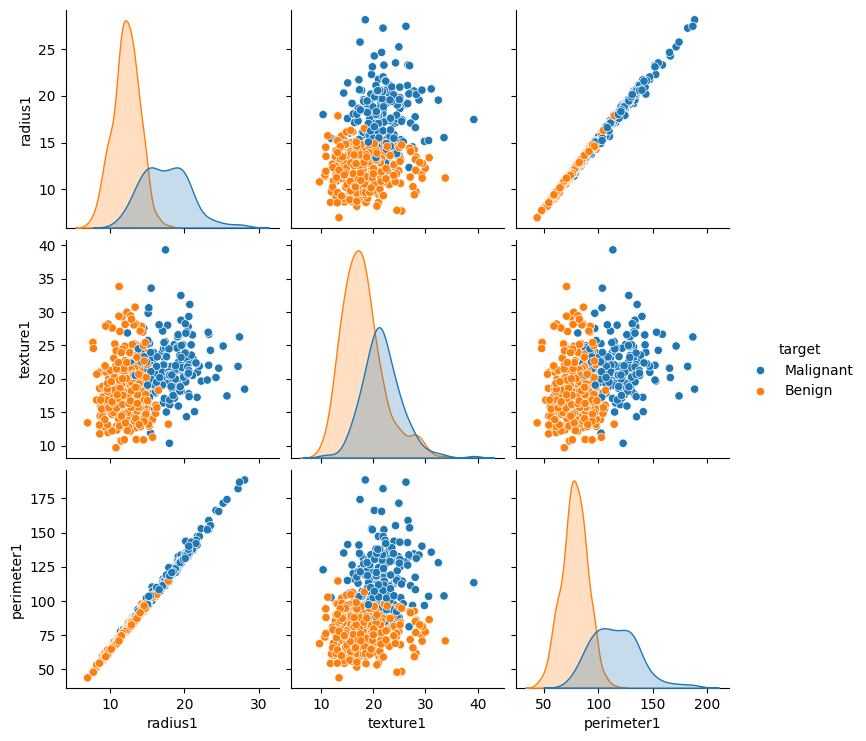

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#combine X and y into one df for visualization
df = X.copy()
df['target'] = y_encoded
df['target'] = df['target'].map({0: 'Benign', 1: 'Malignant'}) 

sns.pairplot(df.loc[:, ['radius1', 'texture1', 'perimeter1', 'target']], hue = 'target') #malignant tumors seem to be larger, bigger range of sizes between 100-150
plt.show()

#classes are highly separable - model accuracy should be very high

In [7]:
print(df.groupby('target').mean())

             radius1   texture1  perimeter1       area1  smoothness1  \
target                                                                 
Benign     12.146524  17.914762   78.075406  462.790196     0.092478   
Malignant  17.462830  21.604906  115.365377  978.376415     0.102898   

           compactness1  concavity1  concave_points1  symmetry1  \
target                                                            
Benign         0.080085    0.046058         0.025717   0.174186   
Malignant      0.145188    0.160775         0.087990   0.192909   

           fractal_dimension1  ...    radius3   texture3  perimeter3  \
target                         ...                                     
Benign               0.062867  ...  13.379801  23.515070   87.005938   
Malignant            0.062680  ...  21.134811  29.318208  141.370330   

                 area3  smoothness3  compactness3  concavity3  \
target                                                          
Benign      558.899440 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, 
                                                    stratify = y_encoded,
                                                    test_size = 0.2,
                                                    random_state = 42)

#scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [9]:
#Build baseline MLP model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#Define simple sequential model
model = Sequential([
    Dense(16, input_shape = (X_train_scaled.shape[1],), activation = 'relu'),
    Dropout(0.2),
    Dense(8, activation = 'relu'),
    Dense(1, activation = 'sigmoid') #Output for binary classification 
])

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

#Callbacks
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5,
    patience = 3,
    verbose = 1
)

#Training
history = model.fit(X_train_scaled, y_train,
                    epochs = 50,
                    batch_size = 16,
                    validation_split = 0.1,
                    callbacks = [early_stopping, lr_scheduler],
                    verbose = 1)

test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f"Test accuracy: {test_acc:.4f}")


2025-06-10 01:56:32.511096: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-10 01:56:32.770664: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-10 01:56:32.926732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749520593.212799    2667 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749520593.275766    2667 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749520593.923322    2667 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Epoch 1/50


/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-10 01:56:37.034024: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4552 - loss: 0.7740 - val_accuracy: 0.6957 - val_loss: 0.6341 - learning_rate: 0.0010
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7546 - loss: 0.6015 - val_accuracy: 0.8261 - val_loss: 0.5373 - learning_rate: 0.0010
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8186 - loss: 0.4954 - val_accuracy: 0.9130 - val_loss: 0.4404 - learning_rate: 0.0010
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8637 - loss: 0.4062 - val_accuracy: 0.9348 - val_loss: 0.3469 - learning_rate: 0.0010
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9040 - loss: 0.3187 - val_accuracy: 0.9348 - val_loss: 0.2735 - learning_rate: 0.0010
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9112 - loss: 0.2841 - val_accuracy: 0.9348 - val_loss: 0.2201 - learning_rate: 0.0010
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9241 - loss: 0.2146 - val_accuracy: 0.9348 - va

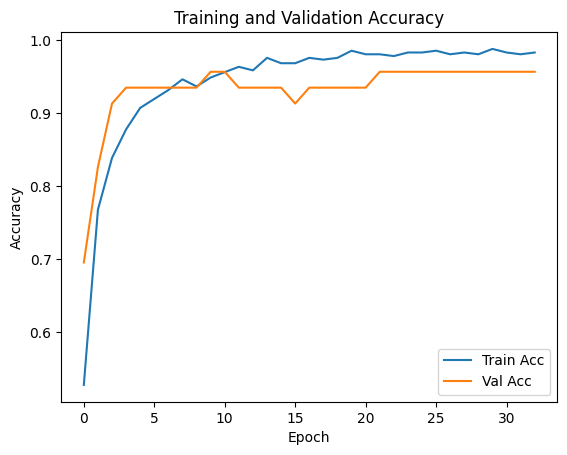

In [10]:
plt.plot(history.history['accuracy'], label = 'Train Acc')
plt.plot(history.history['val_accuracy'], label = 'Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


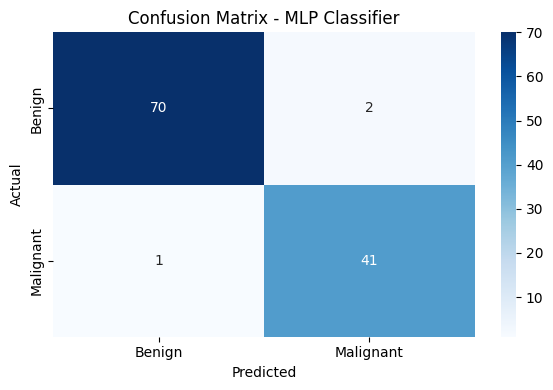

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype('int32').ravel()

#confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Benign', 'Malignant']

plt.figure(figsize = (6,4))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = labels, yticklabels = labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - MLP Classifier')
plt.tight_layout()
plt.show()